In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from nilearn.glm.first_level import make_first_level_design_matrix
import pandas as pd
import seaborn as sns
import random
random.seed(92308572030)

/Users/zeynepenkavi/.pyenv/versions/3.8.3/envs/py-dvl-fmri/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


Variable length stimulus

In [2]:
tr = 1.0
nscans = 200
frame_times = np.arange(nscans) * tr
onsets = np.arange(0, nscans, 20)
durations = np.random.normal(loc=2.5, scale=1, size=10)
# amplitudes = np.random.normal(loc=1, scale=.5, size=10)

In [3]:
def events_to_timeseries(frame_times, events, label = 'stim', hrf_model = 'spm'):
    
    if hrf_model is not None:
        events['trial_type']=label
    
    # Note I'm not making a design matrix per se here. Just using the function as convenience to make the timeseries from onsets, durations and amplitudes
    ts = make_first_level_design_matrix(frame_times, events, drift_model=None, hrf_model = hrf_model)
    ts['label'] = label
    ts = ts.rename(columns={label:'amplitude'})
    ts = ts[['label', 'amplitude']]
    ts['time'] = ts.index
    
    return ts

In [39]:
def get_b_est(dv, des_mat):
    dv = dv['amplitude']
    des_mat = des_mat.values
    b_est = np.linalg.inv(des_mat.T.dot(des_mat)).dot(des_mat.T).dot(dv)
    return b_est

In [4]:
stim_events = pd.DataFrame({'onset': onsets, 'duration': durations, 'trial_type': 'stim', 'modulation': 1})
stim = events_to_timeseries(frame_times, stim_events, label = 'stim', hrf_model = None)
stim_conv = events_to_timeseries(frame_times, stim_events, label = 'stim_conv', hrf_model = 'spm')

A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.


This stimulus can induce different responses

- Node responds with longer duration to longer stimulus
- Node responds with higher amplitude to longer stimulus
- Node responds with both a higher amplitude and longer duration
- Node responds with a delay to longer stimulus

What do these look like at node level and at the measurable HDR level?

In [5]:
node1_events = pd.DataFrame({'onset': onsets, 'duration': durations*2, 'trial_type': 'duration', 'modulation': 1})
node1 = events_to_timeseries(frame_times, node1_events, label = 'duration', hrf_model = None)
node1_conv = events_to_timeseries(frame_times, node1_events, label = 'duration_conv', hrf_model = 'spm')

A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.


In [6]:
node2_events = pd.DataFrame({'onset': onsets, 'duration': durations, 'trial_type': 'amplitude', 'modulation': durations*2})
node2 = events_to_timeseries(frame_times, node2_events, label = 'amplitude', hrf_model = None)
node2_conv = events_to_timeseries(frame_times, node2_events, label = 'amplitude_conv', hrf_model = 'spm')

A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.


In [7]:
node3_events = pd.DataFrame({'onset': onsets, 'duration': durations*2, 'trial_type': 'dur_and_amp', 'modulation': durations*2})
node3 = events_to_timeseries(frame_times, node3_events, label = 'dur_and_amp', hrf_model = None)
node3_conv = events_to_timeseries(frame_times, node3_events, label = 'dur_and_amp', hrf_model = 'spm')

A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.


In [8]:
node4_events = pd.DataFrame({'onset': onsets+2, 'duration': durations, 'trial_type': 'shift', 'modulation': 1})
node4 = events_to_timeseries(frame_times, node4_events, label = 'shift', hrf_model = None)
node4_conv = events_to_timeseries(frame_times, node4_events, label = 'shift_conv', hrf_model = 'spm')

A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.


In [9]:
nodes = pd.concat([node1, node2, node3, node4], ignore_index=True)
nodes_conv = pd.concat([node1_conv, node2_conv, node3_conv, node4_conv], ignore_index=True)

In [10]:
# Plot with nodes overlaid

# plt.rcParams["figure.figsize"][0] = 20
# plt.rcParams["figure.figsize"][1] = 5
# fig, a = plt.subplots(2, 1)
# sns.lineplot(data=stim, x="time", y="amplitude", style=True, dashes=[(2,2)], color="black", linewidth=3, ax=a[0])
# sns.lineplot(data=nodes, x="time", y = "amplitude", hue = "label",  ax=a[0])

# sns.lineplot(data=stim_conv, x="time", y="amplitude", style=True, dashes=[(2,2)], color="black", linewidth=3, ax=a[1])
# sns.lineplot(data=nodes_conv, x="time", y = "amplitude", hue = "label",  ax=a[1])

What is problematic below?  

Nodes that respond to longer stimuli with a change in their response duration have convolved responses that are dominated by an increase in amplitude.

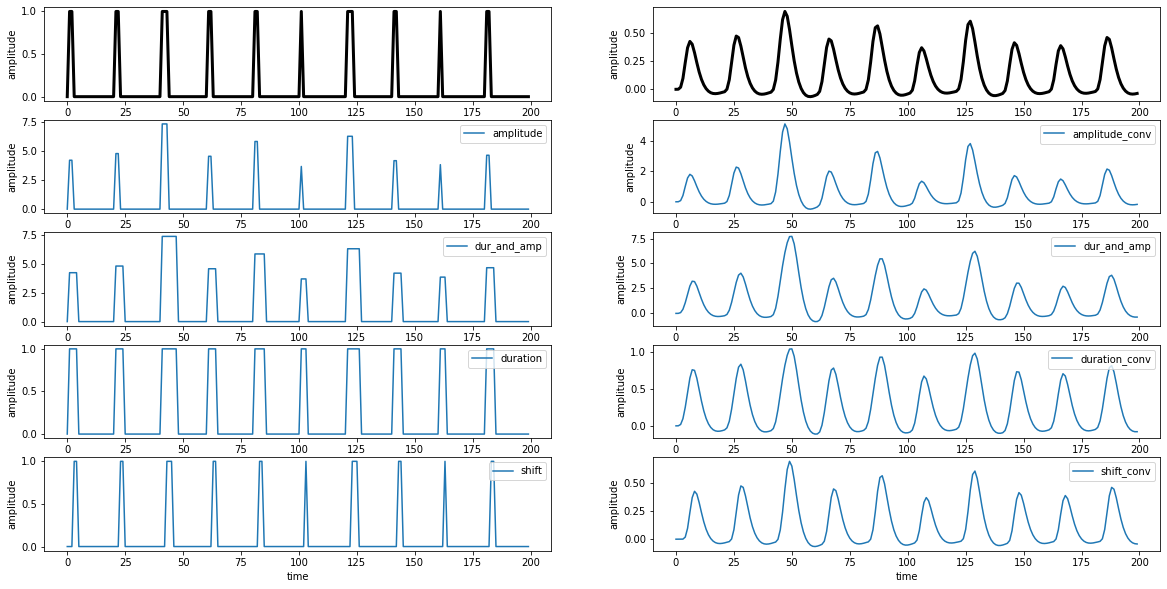

In [11]:
plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 10
fig, a = plt.subplots(5, 2)

sns.lineplot(data=stim, x="time", y="amplitude", color="black", linewidth=3, ax=a[0, 0])
# a[0, 0].set(ylim=(0, 10))
for i,cur_node in enumerate(np.unique(nodes['label'])):
    sns.lineplot(data=nodes.query('label==@cur_node'), x="time", y = "amplitude", label= cur_node, ax=a[i+1, 0])
#     a[i+1, 0].set(ylim=(0, 10))
    
sns.lineplot(data=stim_conv, x="time", y="amplitude", color="black", linewidth=3, ax=a[0, 1])
# a[0, 1].set(ylim=(0, 10))
for i,cur_node in enumerate(np.unique(nodes_conv['label'])):
    sns.lineplot(data=nodes_conv.query('label==@cur_node'), x="time", y = "amplitude", label= cur_node, ax=a[i+1, 1])
#     a[i+1, 1].set(ylim=(0, 10))


- Design 1 - 1 regressor, duration = stim_dur, amplitude = stim_amplitude  
- Design 2 - 2 regressors  
    - Reg 1 duration = mean dur, amplitude = stim_amplitude --> captures amplitude effects 
    - Reg 2 duration = mean_dur, amplitude = stim_dur - mean_dur  --> captures duration effects
    
What is the expected result for each node in each design?

What does stim look like when decomposed?

In [29]:
reg1_events = pd.DataFrame({'onset': onsets, 'duration': durations.mean(), 'trial_type': 'reg1', 'modulation': 1})
reg1 = events_to_timeseries(frame_times, reg1_events, label = 'reg1', hrf_model = None)
reg1_conv = events_to_timeseries(frame_times, reg1_events, label = 'reg1_conv', hrf_model = 'spm')

reg2_events = pd.DataFrame({'onset': onsets, 'duration': durations.mean(), 'trial_type': 'reg2', 'modulation': durations - durations.mean()})
reg2 = events_to_timeseries(frame_times, reg2_events, label = 'reg2', hrf_model = None)
reg2_conv = events_to_timeseries(frame_times, reg2_events, label = 'reg2_conv', hrf_model = 'spm')

A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.


<AxesSubplot:xlabel='time', ylabel='amplitude'>

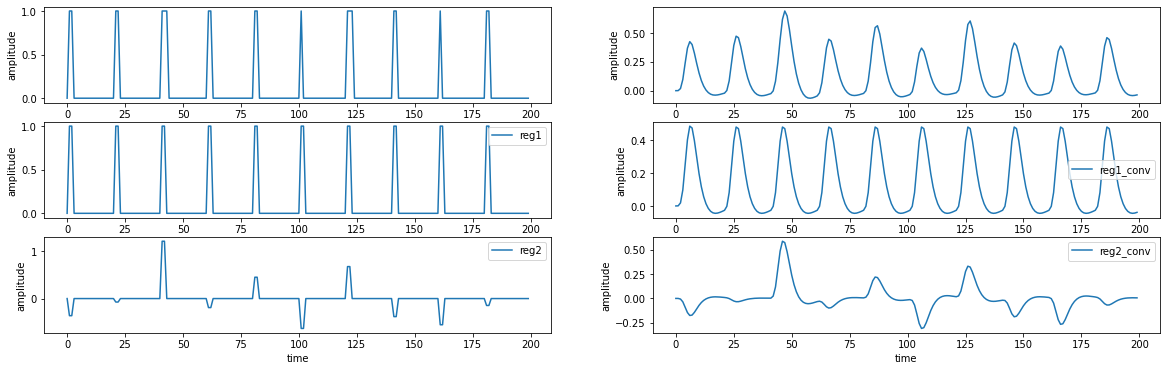

In [32]:

plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 6
fig, a = plt.subplots(3, 2)

sns.lineplot(data = stim, x="time", y="amplitude",ax=a[0,0])
sns.lineplot(data = reg1, x="time", y="amplitude",ax=a[1,0], label='reg1')
sns.lineplot(data = reg2, x="time", y="amplitude",ax=a[2,0], label='reg2')

sns.lineplot(data = stim_conv, x="time", y="amplitude",ax=a[0,1])
sns.lineplot(data = reg1_conv, x="time", y="amplitude",ax=a[1,1], label='reg1_conv')
sns.lineplot(data = reg2_conv, x="time", y="amplitude",ax=a[2,1], label='reg2_conv')


In [41]:
des_mat2_events = pd.concat([reg1_events, reg2_events], ignore_index=True)
des_mat2 = make_first_level_design_matrix(frame_times, des_mat2_events, drift_model=None, hrf_model = 'spm')

A 'modulation' column was found in the given events data and is used.


In [57]:
betas = np.vstack((get_b_est(node1_conv, des_mat2), get_b_est(node2_conv, des_mat2), get_b_est(node3_conv, des_mat2), get_b_est(node4_conv, des_mat2)))

pd.DataFrame(betas, columns=['reg1_amp', 'reg2_dur', 'const'], index=['duration','amplitude','dur_and_amp', 'shift'])

,reg1_amp,reg2_dur,const
duration,1.520581,0.340491,0.060885
amplitude,5.118745,4.177682,0.012964
dur_and_amp,7.569963,5.364735,0.359622
shift,0.698401,0.221190,0.038054


In [58]:
des_mat1 = make_first_level_design_matrix(frame_times, stim_events, drift_model=None, hrf_model = 'spm')

betas = np.vstack((get_b_est(node1_conv, des_mat1), get_b_est(node2_conv, des_mat1), get_b_est(node3_conv, des_mat1), get_b_est(node4_conv, des_mat1)))

pd.DataFrame(betas, columns=['reg1_amp', 'const'], index=['duration','amplitude','dur_and_amp', 'shift'])

A 'modulation' column was found in the given events data and is used.


,reg1_amp,const
duration,1.538729,0.058069
amplitude,5.567912,-0.044931
dur_and_amp,8.430059,0.249795
shift,0.729133,0.033978
